# 1. Introduction
This notebook contains (slightly theoretical) workflow for web services exposed by the EIDA (European Integrated Data Archive) Federation, focused on the EIDAWS-WFCatalog service and its functionalities allowing users to filter out low quality and low coverage data before downloading it to the local machine.

In this example we are going to:

1. Retrieve seismic event information from FDSNWS-Event catalogue offered by [GFZ](https://www.gfz-potsdam.de/) EIDA Node:
    * Date:
        * 📅 start date = 2020-01-01
        * 📅 end date = 2020-06-01
    * Event characteristics:
        * 🎚️ minimum magnitude = 5
    * Coordinates:
        * 🌐 minimum latitude = 40°N
        * 🌐 maximum latitude = 45°N
        * 🌐 minimum longitude = 17°E
        * 🌐 maximum longitude = 25°E
1. Using [FDSNWS-Station](https://www.orfeus-eu.org/data/eida/webservices/station/) web service, list all stations available in the same bounding box we used for our event search:
    * 🌐 minimum latitude = 40°N
    * 🌐 maximum latitude = 45°N
    * 🌐 minimum longitude = 17°E
    * 🌐 maximum longitude = 25°E
1. Using [EIDAWS-WFCatalog](https://www.orfeus-eu.org/data/eida/webservices/wfcatalog/) service, we are going to exclude all stations which do not meet following criteria:
    * At least 95% data coverage on the day of the event
    * Maximum of 5 gaps
    * Sum of gaps lower than 50 seconds
    * No overlaps
1. Using [FDSNWS-Dataselect](https://www.orfeus-eu.org/data/eida/webservices/dataselect/) web service, we are going to download miniSEED files containing the waveforms from a time window starting 5 minutes before and ending 15 minutes after, relative to the event origin time
1. Using [FDSNWS-Station](https://www.orfeus-eu.org/data/eida/webservices/station/) web service, we are going to download StationXML file containing channel level station and instrumentation metadata
1. At the end we are going to quickly demo the GUI-based tools based on the [EIDAWS-WFCatalog](https://www.orfeus-eu.org/data/eida/webservices/wfcatalog/) web service, available via [data quality page](https://www.orfeus-eu.org/data/eida/quality/) on the [orfeus-eu.org](https://orfeus-eu.org).

# 1.1. Approach

For downloading metadata (FDSNWS-Station), waveforms (FDSNWS-Dataselect) and metrics (EIDAWS-WFCatalog) we are going to use [EIDAWS-Federator](http://eida-federator.ethz.ch/) gateway. This means that data will be requested using:

```python
read_events(
    pathname_or_url=None,
    format=None,
    **kwargs
)
```

and

```python
read(
    pathname_or_url=None,
    format=None,
    headonly=False,
    starttime=None,
    endtime=None,
    nearest_sample=True,
    dtype=None,
    apply_calib=False,
    check_compression=True,
    **kwargs
)
```

rather than using the `RoutingClient` utilizing the [EIDAWS-Routing](https://www.orfeus-eu.org/data/eida/webservices/routing/):

```python
from obspy.clients.fdsn import RoutingClient
from obspy import UTCDateTime

rsClient = RoutingClient("eida-routing")
st = rsClient.get_waveforms(
    network="Z3",
    channel="HHZ",
    starttime=UTCDateTime(2016, 3, 1),
    endtime=UTCDateTime(2016, 3, 1, 0, 2, 0)
)
```

⚠️ Please keep in mind that [EIDAWS-Federator](http://eida-federator.ethz.ch/) only provides acces to open data, so if your intention is to download restricted datasets, please refer to [EIDA/userfeedback](https://github.com/EIDA/userfeedback) GitHub repository for instructions.

⚠️ ObsPy (as of v1.2.2) does not implement methods to work with EIDAWS-WFCatalog, this service needs to be called directly.

# 2. Finding event
Lets start by finding an event. Below two completely different approaches have been presented:
* Downloading event XML document directly from FDSNWS-Event web service
* Downloading event information using ObsPy library


In [16]:
# Import libraries required to process raw web service response
import requests
import xml.etree.ElementTree as ET

In [17]:
# Set the encoding and XML namespace
ENCODING = "utf-8"
NSMAP = {'mw': 'http://quakeml.org/xmlns/bed/1.2'}

# Define start and end dates for event and station searches
start = "2020-01-01"
end = "2020-06-01"

# Define event minimum magnitude
min_mag = 5

# Define the bounding box for event and station searches
min_lat = 40
max_lat = 45
min_lon = 17
max_lon = 25

In [18]:
# Build URL to retrieve event information from event catalogue hosted by GFZ
events_url = (
    f"http://geofon.gfz-potsdam.de/fdsnws/event/1/query?"
    f"start={start}&end={end}&"
    f"minmag={min_mag}&"
    f"minlat={min_lat}&minlon={min_lon}&"
    f"maxlat={max_lat}&maxlon={max_lon}"
)

# With our original parameters, following URL should be built:
# http://geofon.gfz-potsdam.de/fdsnws/event/1/query?start=2020-01-01&end=2020-06-01&minmag=5&minlat=40&minlon=17&maxlat=45&maxlon=25

In [19]:
# Fire the request
r = requests.get(events_url, timeout=10)
r.encoding = ENCODING

# Check the response
if r.status_code == 200:
    # Parse the XML response
    event_root = ET.fromstring(r.text)
    
    # Get the event element
    event_element = event_root.find("./mw:eventParameters/*", namespaces=NSMAP)

    # Get event ID from event_element attribute
    event_id = event_element.get("publicID")

    # Find event magnitude element
    event_magnitude_element = event_element.find("./mw:magnitude/mw:mag/mw:value", namespaces=NSMAP)

    # Get magnitude value from event_magnitude_element
    event_magnitude = event_magnitude_element.text

    # Get event origin time element
    event_origin_time_element = event_element.find("./mw:origin/mw:time/mw:value", namespaces=NSMAP)

    # Get origin time value from event_origin_time_element
    event_origin_time = event_origin_time_element.text

    print(f"Event with ID: {event_id} happened on {event_origin_time} and had magnitude equal to: {event_magnitude}")
else:
    print("Something went wrong...")

Event with ID: smi:org.gfz-potsdam.de/geofon/gfz2020bywr happened on 2020-01-28T20:15:10.670309Z and had magnitude equal to: 5.062193141


And now with ObsPy...

In [20]:
from obspy import read_events

# Read events using the same URL
evts = read_events(events_url)

# Print retrieved events
for e in evts:
    print(e)

Event:	2020-01-28T20:15:10.670309Z | +41.433,  +19.569 | 5.062193141 M  | automatic

	            resource_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/gfz2020bywr")
	          creation_info: CreationInfo(agency_id='GFZ', creation_time=UTCDateTime(2020, 1, 28, 20, 16, 31, 618036))
	    preferred_origin_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/Origin/20200128202144.356462.2018953")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/Origin/20200128202144.356462.2018953/netMag/M")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements


ℹ️ Users are free to choose how they download data from EIDA, but for convenience we will continue using ObsPy throughout the rest of this notebook. 🦥

# 3. Finding stations

In [21]:
from obspy import read_inventory

# Build URL using EIDA Federator and our defined parameters
stations_url = (
    f"http://eida-federator.ethz.ch/fdsnws/station/1/query?"
    f"start={start}&end={end}&"
    f"minlat={min_lat}&minlon={min_lon}&"
    f"maxlat={max_lat}&maxlon={max_lon}"
)

inv = read_inventory(stations_url)

print(inv)

Inventory created at 2021-03-26T10:15:22.409085Z
	Sending institution: EIDA-Federator (EIDA)
	Contains:
		Networks (15):
			AC, BS, CR, EG, HI, HL, HT, IS, IV, ME, MN, MT, OT, RO, SJ
		Stations (70):
			AC.BCI (Bajram Curri)
			AC.KBN (Korce)
			AC.LSK (Leskovik)
			AC.PHP (Peshkopi)
			AC.PUK (Puke, Albania)
			AC.VLO (Vlore, Albania)
			BS.BLKB (Belogradchik)
			BS.KOZAM (Kozlodui)
			BS.MALO (Malo)
			BS.MNNAM (Montana)
			BS.PLVAM (Vidin)
			BS.PLVB (Pleven)
			CR.DBRK (Dubrovnik, Croatia)
			CR.MAKA (Makarska, Croatia)
			CR.RIC (Ricice, Croatia)
			EG.MMAA (Museum_Macedonian_Struggle,Thessaloniki,Greece)
			EG.SHTA (Scholi_Tiflon,Thessaloniki,Greece)
			EG.STC (Stivos Community Building)
			EG.STE (Stivos_Church,EUROSEISTEST,Greece)
			HI.DRA2 (Hospital,Drama,Eastern Macedonia)
			HI.LMS2 (TownHall,Laimos,Florina,Western Macedonia)
			HI.THS1 (HealthCenter,Prinos,Thasos Island)
			HL.KVLA (Kavala, Greece)
			HL.KZN (Kozani,Greece)
			HL.NVR (Nevrokopi, Greece)
			HL.PENT (Pentalo

Let's try to visualize our event and surrounding stations. Please notice that stations in this area are hosted by various EIDA nodes:
- NOA
- NIEP
- GFZ
- INGV
- ODC

![](img/eventAndStations.png)

⚠️ This is a static image and will not change after adjusting the input parameters...

# 4. Filter stations which do not meet our quality criteria
We want to download data from stations which have:
1. At least 95% data availability on the day of the event
1. Maximum of 5 gaps
1. Sum of gaps lower than 50 seconds
1. No overlaps

First, lets see what default EIDAWS-WFCatalog response offers...

http://eida-federator.ethz.ch/eidaws/wfcatalog/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HL&station=KZN&channel=HHZ&include=all

```json
[{
    "version": "1.0.0",
    "producer": {
        "name": "EIDA NODE",
        "agent": "ObsPy mSEED-QC",
        "created": "2020-01-29T08:39:49.718Z"
    },
    "station": "KZN",
    "network": "HL",
    "location": "",
    "channel": "HHZ",
    "num_gaps": 3,
    "num_overlaps": 0,
    "sum_gaps": 5,
    "sum_overlaps": 0,
    "max_gap": 2,
    "max_overlap": null,
    "record_length": [512],
    "sample_rate": [100],
    "percent_availability": 99.99421296296296,
    "encoding": ["STEIM2"],
    "num_records": 16260,
    "start_time": "2020-01-28T00:00:00.000Z",
    "end_time": "2020-01-29T00:00:00.000Z",
    "format": "miniSEED",
    "quality": "D",
    "sample_min": -21263,
    "sample_max": 25253,
    "sample_mean": 77.38187557150297,
    "sample_median": 79,
    "sample_stdev": 1157.057209432005,
    "sample_rms": 1159.6419018669262,
    "sample_lower_quartile": 37,
    "sample_upper_quartile": 121,
    "miniseed_header_percentages": {
        "timing_quality_mean": 10,
        "timing_quality_median": 10,
        "timing_quality_lower_quartile": 10,
        "timing_quality_upper_quartile": 10,
        "timing_quality_min": 10,
        "timing_quality_max": 10,
        "timing_correction": 0,
        "io_and_clock_flags": {
            "short_record_read": 0,
            "station_volume": 0,
            "start_time_series": 0,
            "end_time_series": 0,
            "clock_locked": 0
        },
        "data_quality_flags": {
            "amplifier_saturation": 0,
            "digitizer_clipping": 0,
            "spikes": 0,
            "glitches": 0,
            "missing_padded_data": 0,
            "telemetry_sync_error": 0,
            "digital_filter_charging": 0,
            "suspect_time_tag": 0
        },
        "activity_flags": {
            "calibration_signal": 0,
            "time_correction_applied": 0,
            "event_begin": 0,
            "event_end": 0,
            "positive_leap": 0,
            "negative_leap": 0
        }
    }
}]
```

In [22]:
import json
from datetime import datetime, timedelta

In [23]:
# Convert string representation of origin time to datetime object
dt_origin = datetime.strptime(event_origin_time, "%Y-%m-%dT%H:%M:%S.%fZ")

# Define relative time windows using event origin time
dt_start = dt_origin - timedelta(minutes=5)
dt_end = dt_origin + timedelta(minutes=15)

# Get ISO8601 representation of our time window
dt_start_iso = dt_start.isoformat()
dt_end_iso = dt_end.isoformat()

In [24]:
# Channels we are interested in
# channels will be downloaded only if all specified components are present and validated
required_channels = {
    "BH?": ["BHE", "BHN", "BHZ"],
    "HH?": ["HHE", "HHN", "HHZ"],
    "LH?": ["LHE", "LHN", "LHZ"],
}

In [25]:
def validate_station(string):
    """Our validating function which takes WFCatalog response json and returns
    list of network/station/channels for which all components are
    present and validated against our criteria.

    Args:
        string (string): JSON response from EIDAWS-WFCatalog web service

    Returns:
        []: List of validated networks, stations and channels
        None: If no channels have been found, function returns `None`
    """
    # Parse string to json object
    j = json.loads(string)
    
    # Define channels_found as set to allow only unique values
    channels_found = set()
    channels_validated = []

    for cha in j:
        # Get network station channel identifiers
        network_code = cha["network"]
        station_code = cha["station"]
        channel_code = cha["channel"]
        
        # Get the quality metrics
        availability = int(cha["percent_availability"])
        gaps = int(cha["num_gaps"])
        sum_gaps = int(cha["sum_gaps"])
        overlaps = int(cha["num_overlaps"])
        
        msg = f"{network_code}.{station_code}.{channel_code}: {availability}% coverage, {gaps} gaps ({sum_gaps}s), {overlaps} overlaps."
        if availability < 95 or gaps > 5 or sum_gaps > 50 or overlaps > 0:
            print(f"NOK: {msg}")
        else:
            print(f"OK: {msg}")
            channels_found.add(channel_code.upper())

    # If channel components are present and validated, add them to the channels_validated list
    for c in required_channels.keys():
        if all(e in channels_found for e in required_channels[c]):
            channels_validated.append(c)

    if len(channels_validated) > 0:
        return ",".join(channels_validated)
    else:
        return None

In [26]:
# List of verified stations, will be filled later
validated_stations = []

# Loop through all networks and stations found in the bounding box surrounding our event
for net in inv:
    for sta in net:
        # Build WFCatalog URL (POST method is not avaiable via Federator)
        wfcatalog_url = (
            f"http://eida-federator.ethz.ch/eidaws/wfcatalog/1/query?"
            f"start={dt_start_iso}&end={dt_end_iso}&"
            f"network={net.code}&station={sta.code}"
        )

        # Request the data...
        r = requests.get(wfcatalog_url, timeout=10)
        r.encoding = ENCODING
        
        if r.status_code == 200:
            # Validate station
            cha = validate_station(r.text)
            if cha:
                # Validation passed, add to verified_stations list
                validated_stations.append([net.code, sta.code, cha])
        else:
            # print(f"No data for {net.code}.{sta.code}")
            pass

print("Done!")

OK: IS.MMB1.BHZ: 100% coverage, 0 gaps (0s), 0 overlaps.
NOK: SJ.BBLS.BHE: 100% coverage, 0 gaps (0s), 2 overlaps.
NOK: SJ.BBLS.BHN: 100% coverage, 0 gaps (0s), 2 overlaps.
NOK: SJ.BBLS.BHZ: 100% coverage, 0 gaps (0s), 2 overlaps.
OK: SJ.BEO.BHE: 100% coverage, 0 gaps (0s), 0 overlaps.
OK: SJ.BEO.BHZ: 100% coverage, 0 gaps (0s), 0 overlaps.
OK: SJ.BEO.BHN: 100% coverage, 0 gaps (0s), 0 overlaps.
NOK: SJ.DJES.BHN: 99% coverage, 5 gaps (12s), 571 overlaps.
NOK: SJ.DJES.BHE: 99% coverage, 1 gaps (2s), 681 overlaps.
NOK: SJ.DJES.BHZ: 100% coverage, 0 gaps (0s), 650 overlaps.
NOK: AC.KBN.HHE: 100% coverage, 0 gaps (0s), 1056 overlaps.
NOK: AC.KBN.HHN: 99% coverage, 1 gaps (2s), 1001 overlaps.
NOK: AC.KBN.HHZ: 100% coverage, 0 gaps (0s), 1065 overlaps.
NOK: AC.VLO.HHZ: 100% coverage, 0 gaps (0s), 197 overlaps.
NOK: AC.VLO.HHN: 100% coverage, 0 gaps (0s), 194 overlaps.
NOK: AC.VLO.HHE: 100% coverage, 0 gaps (0s), 221 overlaps.
NOK: HI.DRA2.HNN: 99% coverage, 1 gaps (75s), 0 overlaps.
NOK: HI.

In [27]:
# Import pprint to improve readability
import pprint

# Let's print our validated stations
pp = pprint.PrettyPrinter()
pp.pprint(validated_stations)

[['SJ', 'BEO', 'BH?'],
 ['IV', 'MESG', 'BH?,HH?,LH?'],
 ['HL', 'KZN', 'HH?'],
 ['HL', 'PENT', 'HH?'],
 ['HL', 'PLG', 'HH?'],
 ['HT', 'GRG', 'HH?'],
 ['HT', 'KNT', 'HH?'],
 ['HT', 'LIT', 'HH?'],
 ['HT', 'NEST', 'HH?'],
 ['HT', 'OUR', 'HH?'],
 ['HT', 'SOH', 'HH?'],
 ['HT', 'THAS', 'HH?'],
 ['HT', 'THE', 'HH?'],
 ['MN', 'BLY', 'BH?,HH?,LH?'],
 ['MN', 'PDG', 'BH?,HH?,LH?'],
 ['OT', 'TAR1', 'HH?']]


# 5. Download data for verified stations

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=SJ&station=BEO&channel=BH?
3 Trace(s) in Stream:
SJ.BEO..BHE | 2020-01-28T20:10:07.085000Z - 2020-01-28T20:30:14.235000Z | 20.0 Hz, 24144 samples
SJ.BEO..BHZ | 2020-01-28T20:10:01.805000Z - 2020-01-28T20:30:11.855000Z | 20.0 Hz, 24202 samples
SJ.BEO..BHN | 2020-01-28T20:10:05.575000Z - 2020-01-28T20:30:14.425000Z | 20.0 Hz, 24178 samples


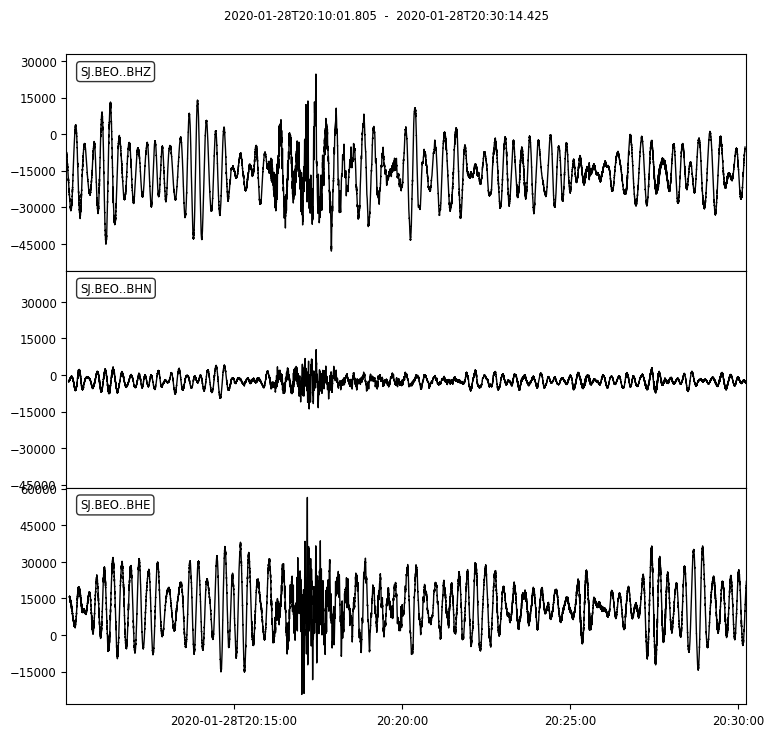

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=IV&station=MESG&channel=BH?,HH?,LH?
9 Trace(s) in Stream:
IV.MESG..BHE | 2020-01-28T20:10:05.395000Z - 2020-01-28T20:30:13.145000Z | 20.0 Hz, 24156 samples
IV.MESG..BHZ | 2020-01-28T20:10:06.695000Z - 2020-01-28T20:30:16.495000Z | 20.0 Hz, 24197 samples
IV.MESG..BHN | 2020-01-28T20:10:03.645000Z - 2020-01-28T20:30:21.545000Z | 20.0 Hz, 24359 samples
IV.MESG..LHE | 2020-01-28T20:09:22.120000Z - 2020-01-28T20:33:00.120000Z | 1.0 Hz, 1419 samples
IV.MESG..LHN | 2020-01-28T20:10:02.120200Z - 2020-01-28T20:30:11.120200Z | 1.0 Hz, 1210 samples
IV.MESG..LHZ | 2020-01-28T20:07:24.120000Z - 2020-01-28T20:30:44.120000Z | 1.0 Hz, 1401 samples
IV.MESG..HHE | 2020-01-28T20:10:09.380000Z - 2020-01-28T20:30:12.240000Z | 100.0 Hz, 120287 samples
IV.MESG..HHZ | 2020-01-28T20:10:09.350000Z - 2020-01-28T20:30:12.620000Z | 100.0 Hz, 120328 samples
IV.MESG..HHN | 2020-01-28T20:10:

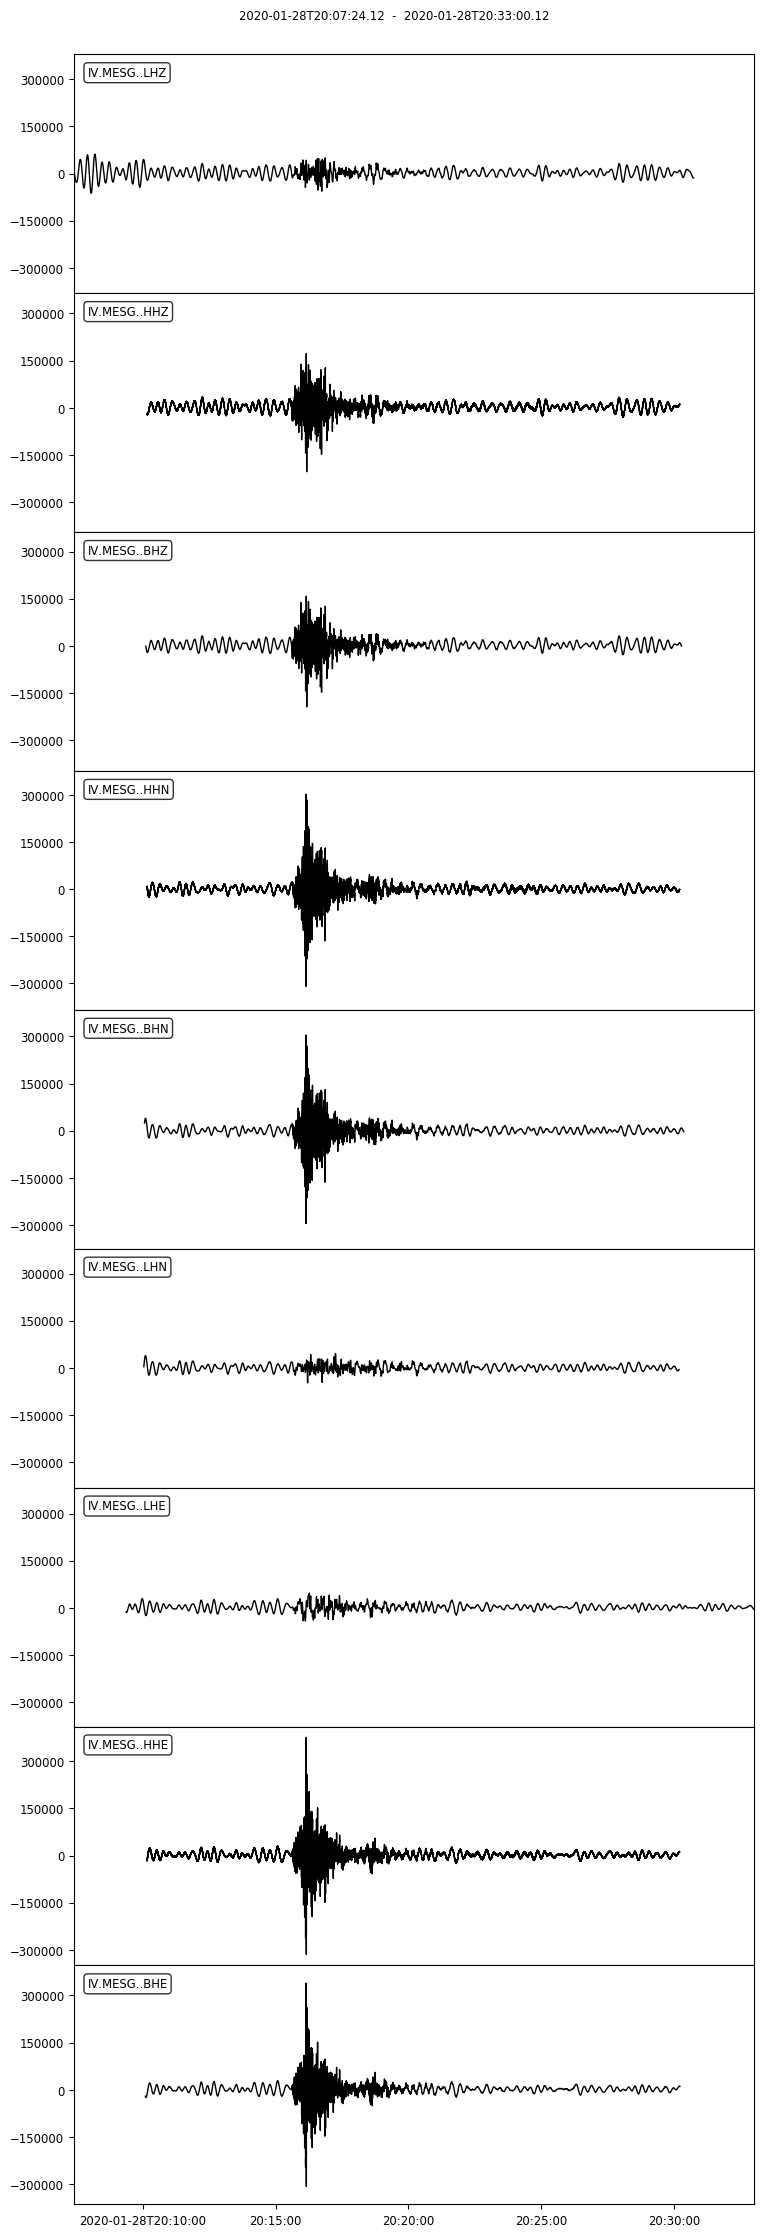

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HL&station=KZN&channel=HH?
3 Trace(s) in Stream:
HL.KZN..HHE | 2020-01-28T20:10:07.330000Z - 2020-01-28T20:30:11.400000Z | 100.0 Hz, 120408 samples
HL.KZN..HHN | 2020-01-28T20:10:10.640000Z - 2020-01-28T20:30:14.080000Z | 100.0 Hz, 120345 samples
HL.KZN..HHZ | 2020-01-28T20:10:08.750000Z - 2020-01-28T20:30:13.330000Z | 100.0 Hz, 120459 samples


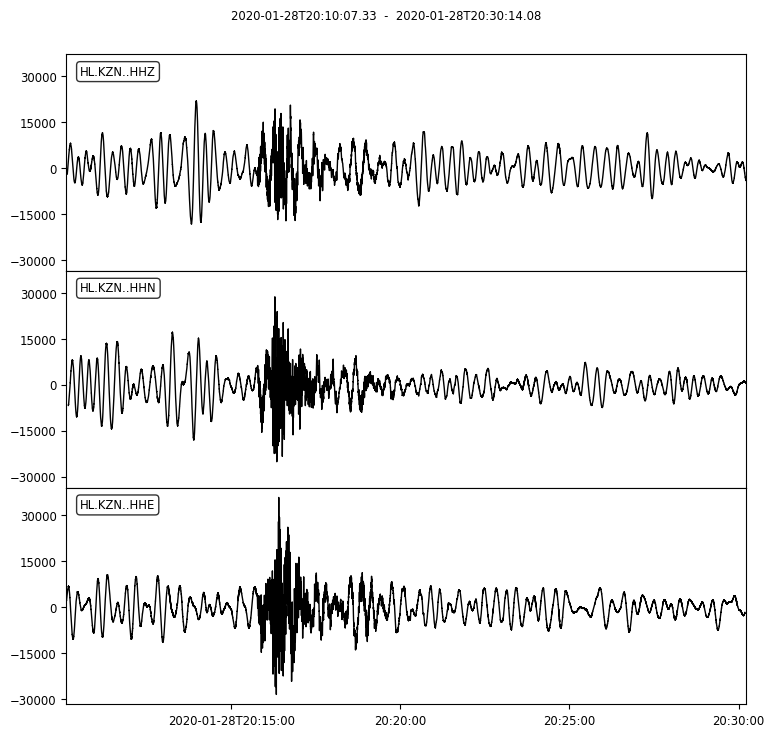

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HL&station=PENT&channel=HH?
3 Trace(s) in Stream:
HL.PENT..HHN | 2020-01-28T20:10:09.190000Z - 2020-01-28T20:30:11.050000Z | 100.0 Hz, 120187 samples
HL.PENT..HHE | 2020-01-28T20:10:07.390000Z - 2020-01-28T20:30:10.890000Z | 100.0 Hz, 120351 samples
HL.PENT..HHZ | 2020-01-28T20:10:09.700000Z - 2020-01-28T20:30:12.650000Z | 100.0 Hz, 120296 samples


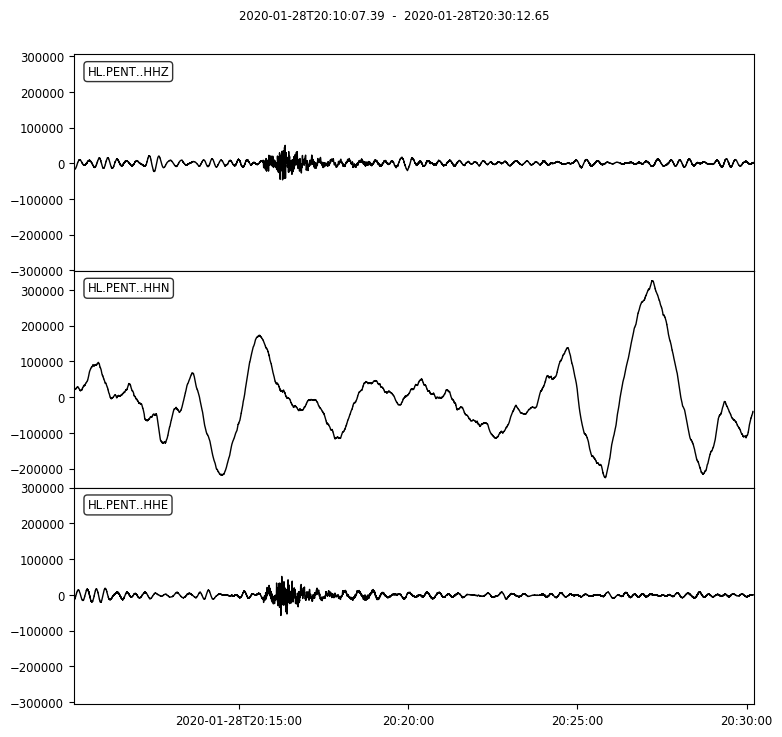

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HL&station=PLG&channel=HH?
3 Trace(s) in Stream:
HL.PLG..HHZ | 2020-01-28T20:10:09.060000Z - 2020-01-28T20:30:13.890000Z | 100.0 Hz, 120484 samples
HL.PLG..HHN | 2020-01-28T20:10:10.430000Z - 2020-01-28T20:30:13.130000Z | 100.0 Hz, 120271 samples
HL.PLG..HHE | 2020-01-28T20:10:08.630000Z - 2020-01-28T20:30:12.350000Z | 100.0 Hz, 120373 samples


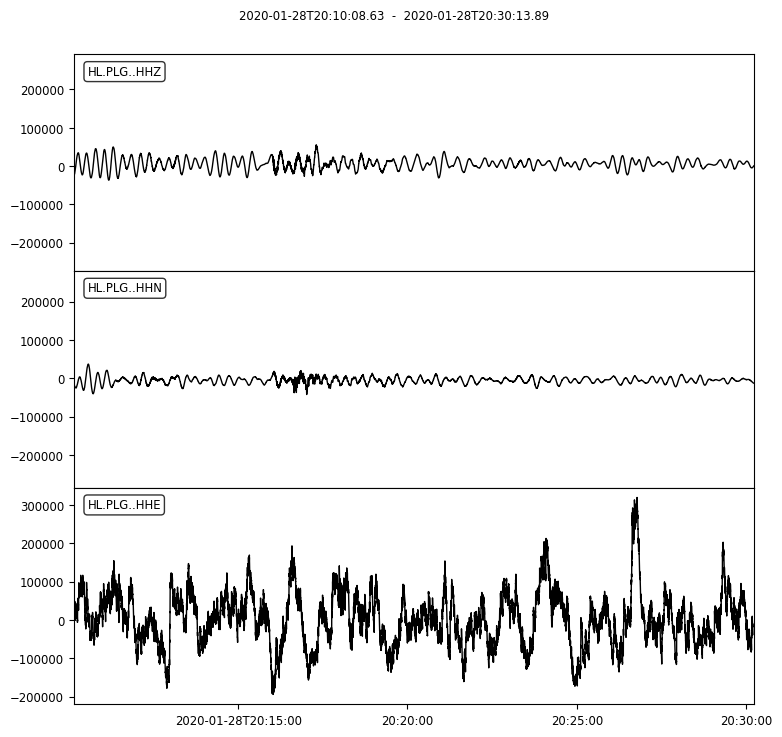

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HT&station=GRG&channel=HH?
3 Trace(s) in Stream:
HT.GRG..HHN | 2020-01-28T20:10:10.320000Z - 2020-01-28T20:30:11.810000Z | 100.0 Hz, 120150 samples
HT.GRG..HHE | 2020-01-28T20:10:09.600000Z - 2020-01-28T20:30:12.710000Z | 100.0 Hz, 120312 samples
HT.GRG..HHZ | 2020-01-28T20:10:06.880000Z - 2020-01-28T20:30:11.210000Z | 100.0 Hz, 120434 samples


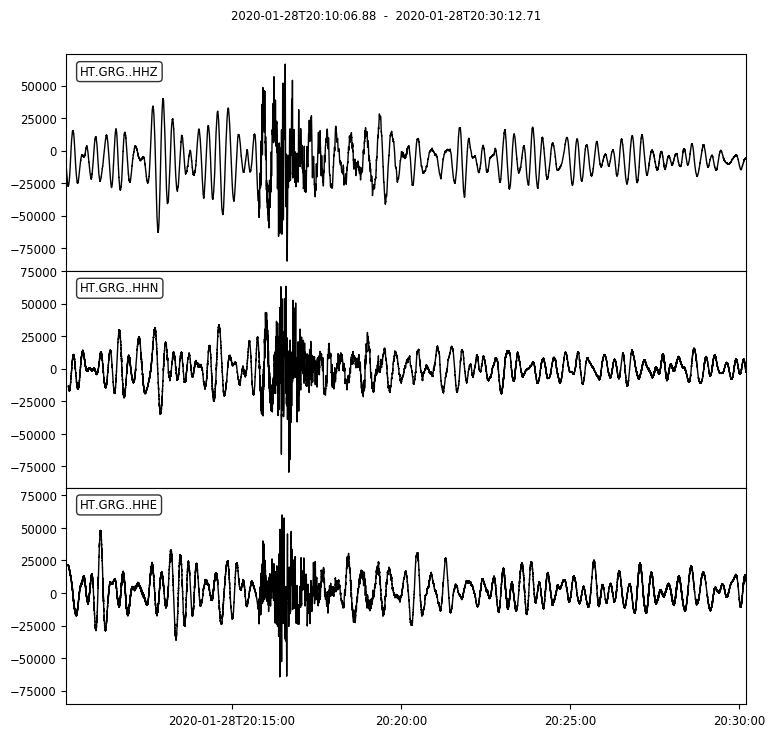

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HT&station=KNT&channel=HH?
3 Trace(s) in Stream:
HT.KNT..HHE | 2020-01-28T20:10:10.600000Z - 2020-01-28T20:30:12.730000Z | 100.0 Hz, 120214 samples
HT.KNT..HHZ | 2020-01-28T20:10:10.530000Z - 2020-01-28T20:30:12.380000Z | 100.0 Hz, 120186 samples
HT.KNT..HHN | 2020-01-28T20:10:09.640000Z - 2020-01-28T20:30:13.430000Z | 100.0 Hz, 120380 samples


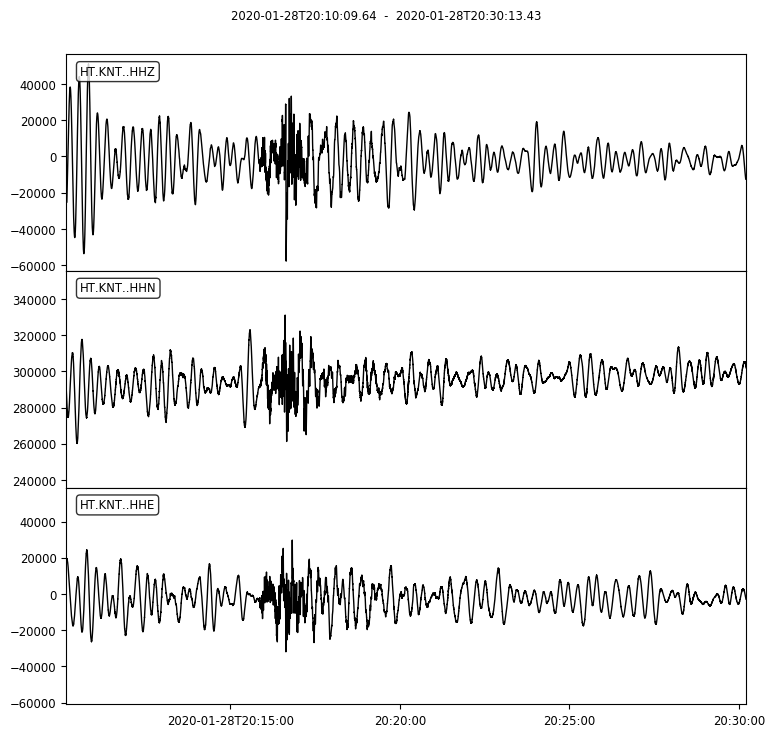

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HT&station=LIT&channel=HH?
3 Trace(s) in Stream:
HT.LIT..HHE | 2020-01-28T20:10:08.180000Z - 2020-01-28T20:30:11.850000Z | 100.0 Hz, 120368 samples
HT.LIT..HHN | 2020-01-28T20:10:07.970000Z - 2020-01-28T20:30:10.880000Z | 100.0 Hz, 120292 samples
HT.LIT..HHZ | 2020-01-28T20:10:08.060000Z - 2020-01-28T20:30:11.810000Z | 100.0 Hz, 120376 samples


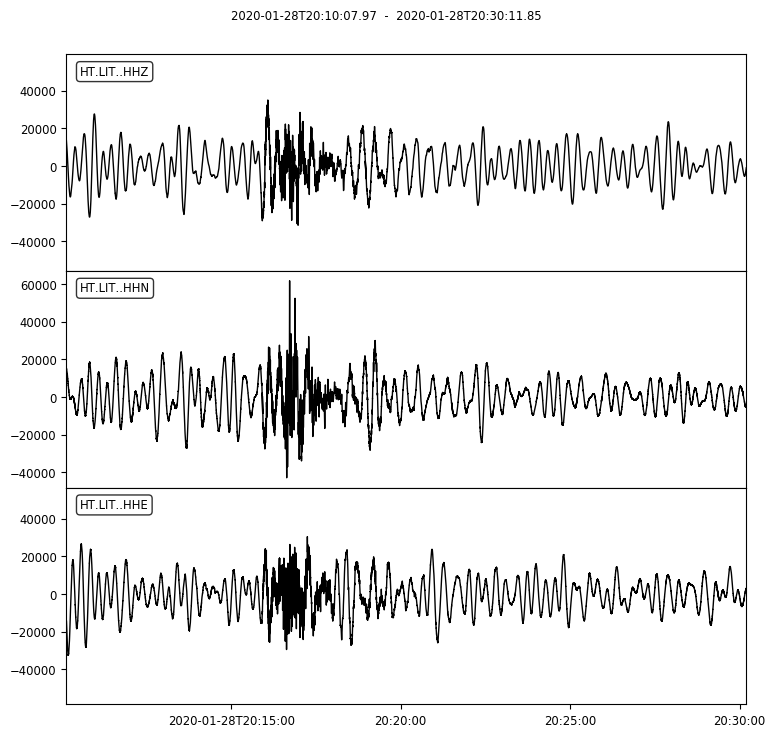

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HT&station=NEST&channel=HH?
3 Trace(s) in Stream:
HT.NEST..HHE | 2020-01-28T20:10:08.020000Z - 2020-01-28T20:30:14.470000Z | 100.0 Hz, 120646 samples
HT.NEST..HHZ | 2020-01-28T20:10:07.010000Z - 2020-01-28T20:30:12.120000Z | 100.0 Hz, 120512 samples
HT.NEST..HHN | 2020-01-28T20:10:08.320000Z - 2020-01-28T20:30:11.050000Z | 100.0 Hz, 120274 samples


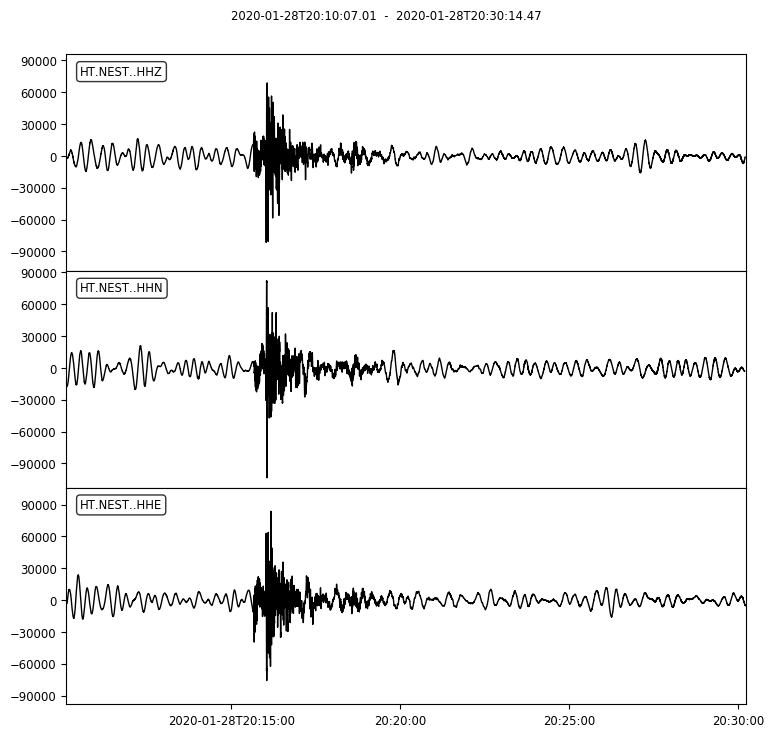

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HT&station=OUR&channel=HH?
3 Trace(s) in Stream:
HT.OUR..HHE | 2020-01-28T20:10:09.000000Z - 2020-01-28T20:30:14.670000Z | 100.0 Hz, 120568 samples
HT.OUR..HHZ | 2020-01-28T20:10:09.740000Z - 2020-01-28T20:30:13.230000Z | 100.0 Hz, 120350 samples
HT.OUR..HHN | 2020-01-28T20:10:08.480000Z - 2020-01-28T20:30:13.550000Z | 100.0 Hz, 120508 samples


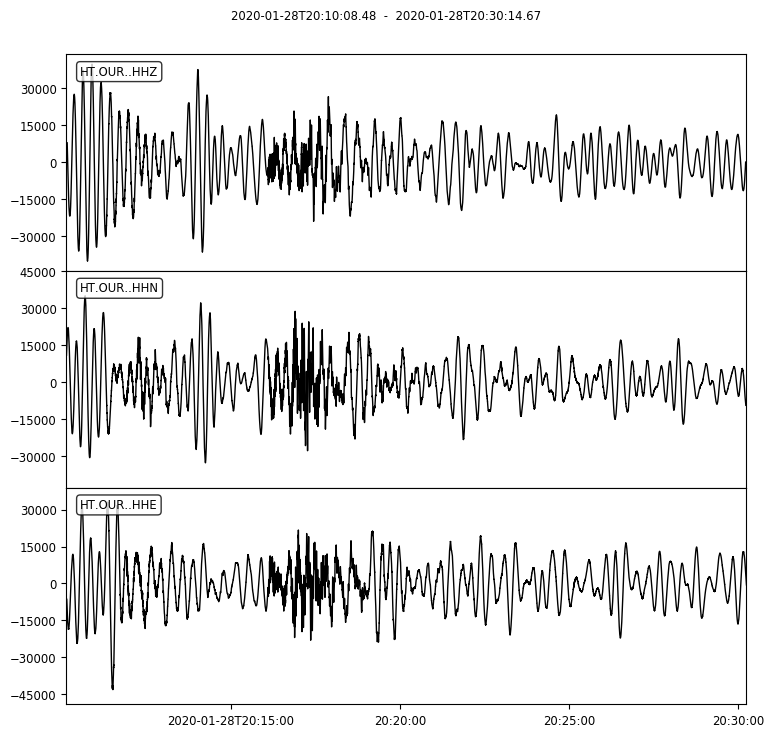

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HT&station=SOH&channel=HH?
3 Trace(s) in Stream:
HT.SOH..HHE | 2020-01-28T20:10:08.900000Z - 2020-01-28T20:30:10.910000Z | 100.0 Hz, 120202 samples
HT.SOH..HHN | 2020-01-28T20:10:07.760000Z - 2020-01-28T20:30:13.430000Z | 100.0 Hz, 120568 samples
HT.SOH..HHZ | 2020-01-28T20:10:07.380000Z - 2020-01-28T20:30:10.930000Z | 100.0 Hz, 120356 samples


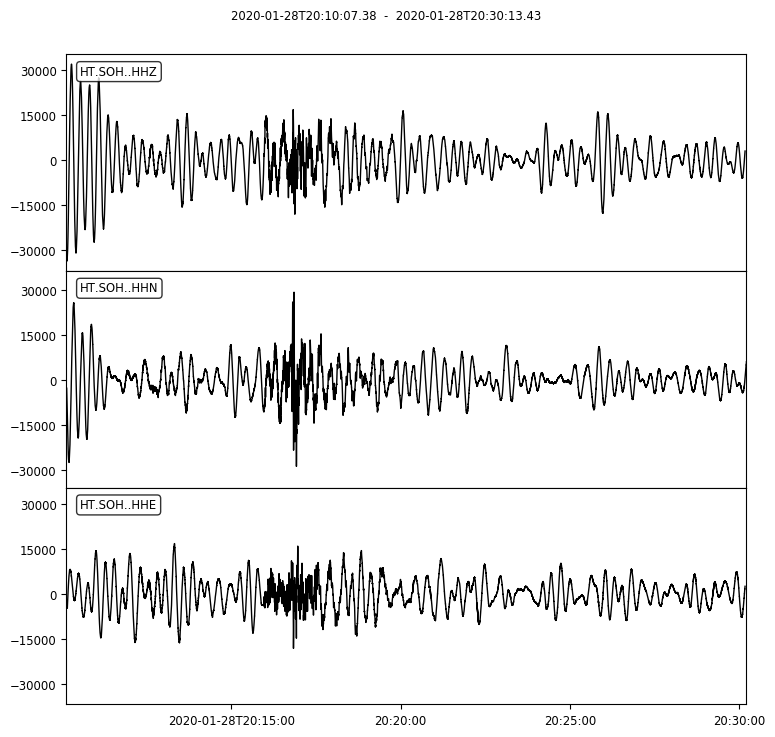

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HT&station=THAS&channel=HH?
3 Trace(s) in Stream:
HT.THAS..HHE | 2020-01-28T20:10:09.010000Z - 2020-01-28T20:30:11.100000Z | 100.0 Hz, 120210 samples
HT.THAS..HHN | 2020-01-28T20:10:08.560000Z - 2020-01-28T20:30:13.070000Z | 100.0 Hz, 120452 samples
HT.THAS..HHZ | 2020-01-28T20:10:08.820000Z - 2020-01-28T20:30:11.510000Z | 100.0 Hz, 120270 samples


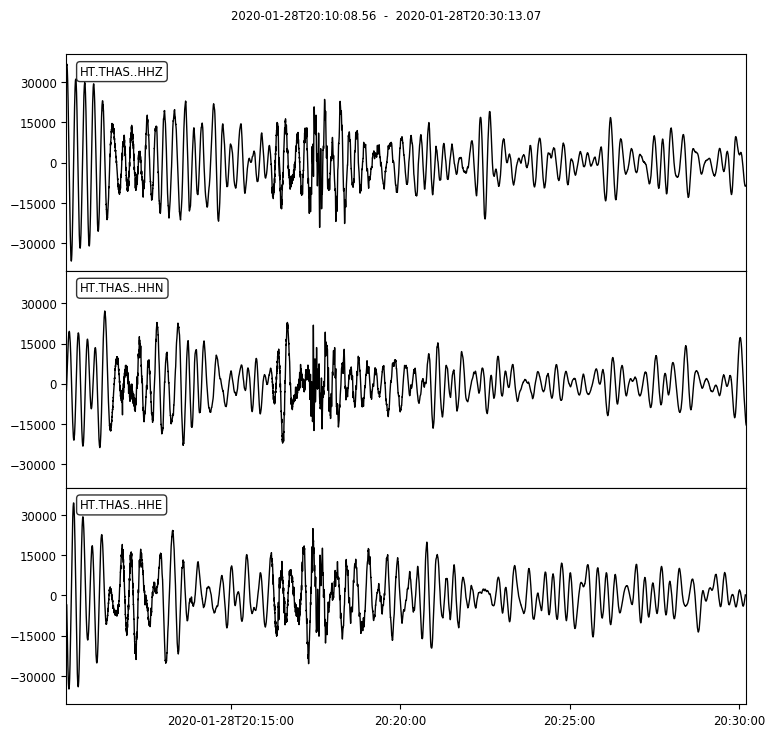

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=HT&station=THE&channel=HH?
3 Trace(s) in Stream:
HT.THE..HHE | 2020-01-28T20:10:08.850000Z - 2020-01-28T20:30:13.280000Z | 100.0 Hz, 120444 samples
HT.THE..HHN | 2020-01-28T20:10:08.740000Z - 2020-01-28T20:30:11.090000Z | 100.0 Hz, 120236 samples
HT.THE..HHZ | 2020-01-28T20:10:08.890000Z - 2020-01-28T20:30:10.880000Z | 100.0 Hz, 120200 samples


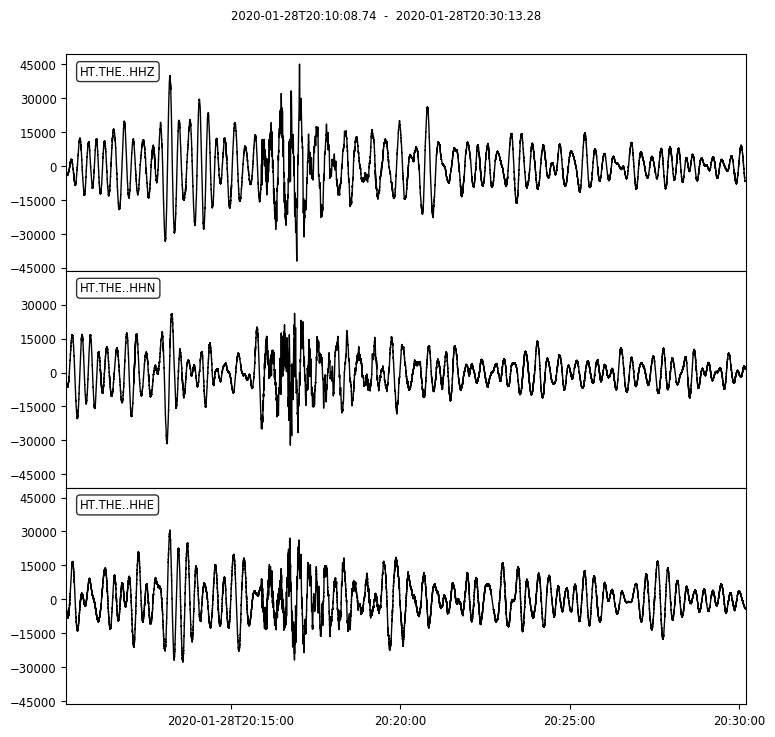

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=MN&station=BLY&channel=BH?,HH?,LH?
9 Trace(s) in Stream:
MN.BLY..BHE | 2020-01-28T20:10:01.419538Z - 2020-01-28T20:30:13.369538Z | 20.0 Hz, 24240 samples
MN.BLY..BHN | 2020-01-28T20:10:05.419538Z - 2020-01-28T20:30:12.369538Z | 20.0 Hz, 24140 samples
MN.BLY..BHZ | 2020-01-28T20:10:08.419538Z - 2020-01-28T20:30:24.369538Z | 20.0 Hz, 24320 samples
MN.BLY..LHE | 2020-01-28T20:08:33.069537Z - 2020-01-28T20:30:51.069537Z | 1.0 Hz, 1339 samples
MN.BLY..LHN | 2020-01-28T20:08:33.069537Z - 2020-01-28T20:30:51.069537Z | 1.0 Hz, 1339 samples
MN.BLY..LHZ | 2020-01-28T20:08:33.069537Z - 2020-01-28T20:30:51.069537Z | 1.0 Hz, 1339 samples
MN.BLY..HHE | 2020-01-28T20:10:07.968392Z - 2020-01-28T20:30:13.958392Z | 100.0 Hz, 120600 samples
MN.BLY..HHN | 2020-01-28T20:10:07.968392Z - 2020-01-28T20:30:12.958392Z | 100.0 Hz, 120500 samples
MN.BLY..HHZ | 2020-01-28T20:10:09.968392Z

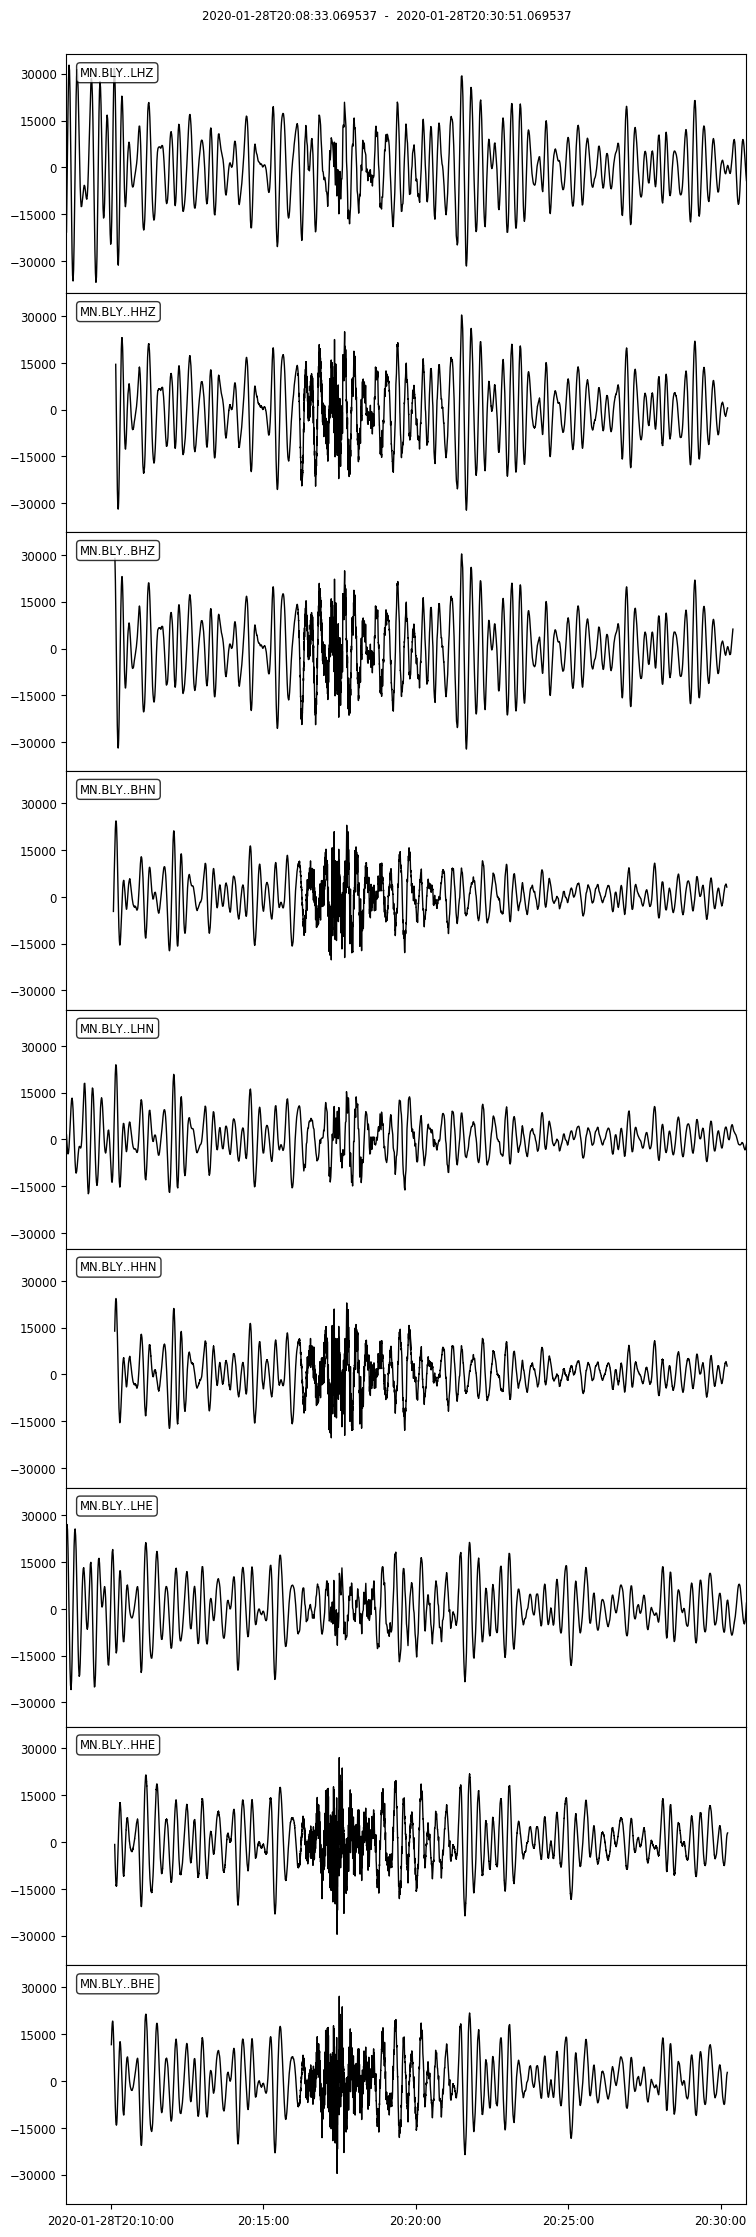

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=MN&station=PDG&channel=BH?,HH?,LH?
9 Trace(s) in Stream:
MN.PDG..BHE | 2020-01-28T20:10:04.419538Z - 2020-01-28T20:30:14.369538Z | 20.0 Hz, 24200 samples
MN.PDG..BHN | 2020-01-28T20:09:55.419538Z - 2020-01-28T20:30:23.369538Z | 20.0 Hz, 24560 samples
MN.PDG..BHZ | 2020-01-28T20:10:06.419538Z - 2020-01-28T20:30:22.369538Z | 20.0 Hz, 24320 samples
MN.PDG..LHE | 2020-01-28T20:09:54.069537Z - 2020-01-28T20:30:29.069537Z | 1.0 Hz, 1236 samples
MN.PDG..LHN | 2020-01-28T20:09:54.069537Z - 2020-01-28T20:30:29.069537Z | 1.0 Hz, 1236 samples
MN.PDG..LHZ | 2020-01-28T20:09:54.069537Z - 2020-01-28T20:30:29.069537Z | 1.0 Hz, 1236 samples
MN.PDG..HHE | 2020-01-28T20:10:09.968392Z - 2020-01-28T20:30:14.958392Z | 100.0 Hz, 120500 samples
MN.PDG..HHZ | 2020-01-28T20:10:07.968392Z - 2020-01-28T20:30:14.958392Z | 100.0 Hz, 120700 samples
MN.PDG..HHN | 2020-01-28T20:10:09.968392Z

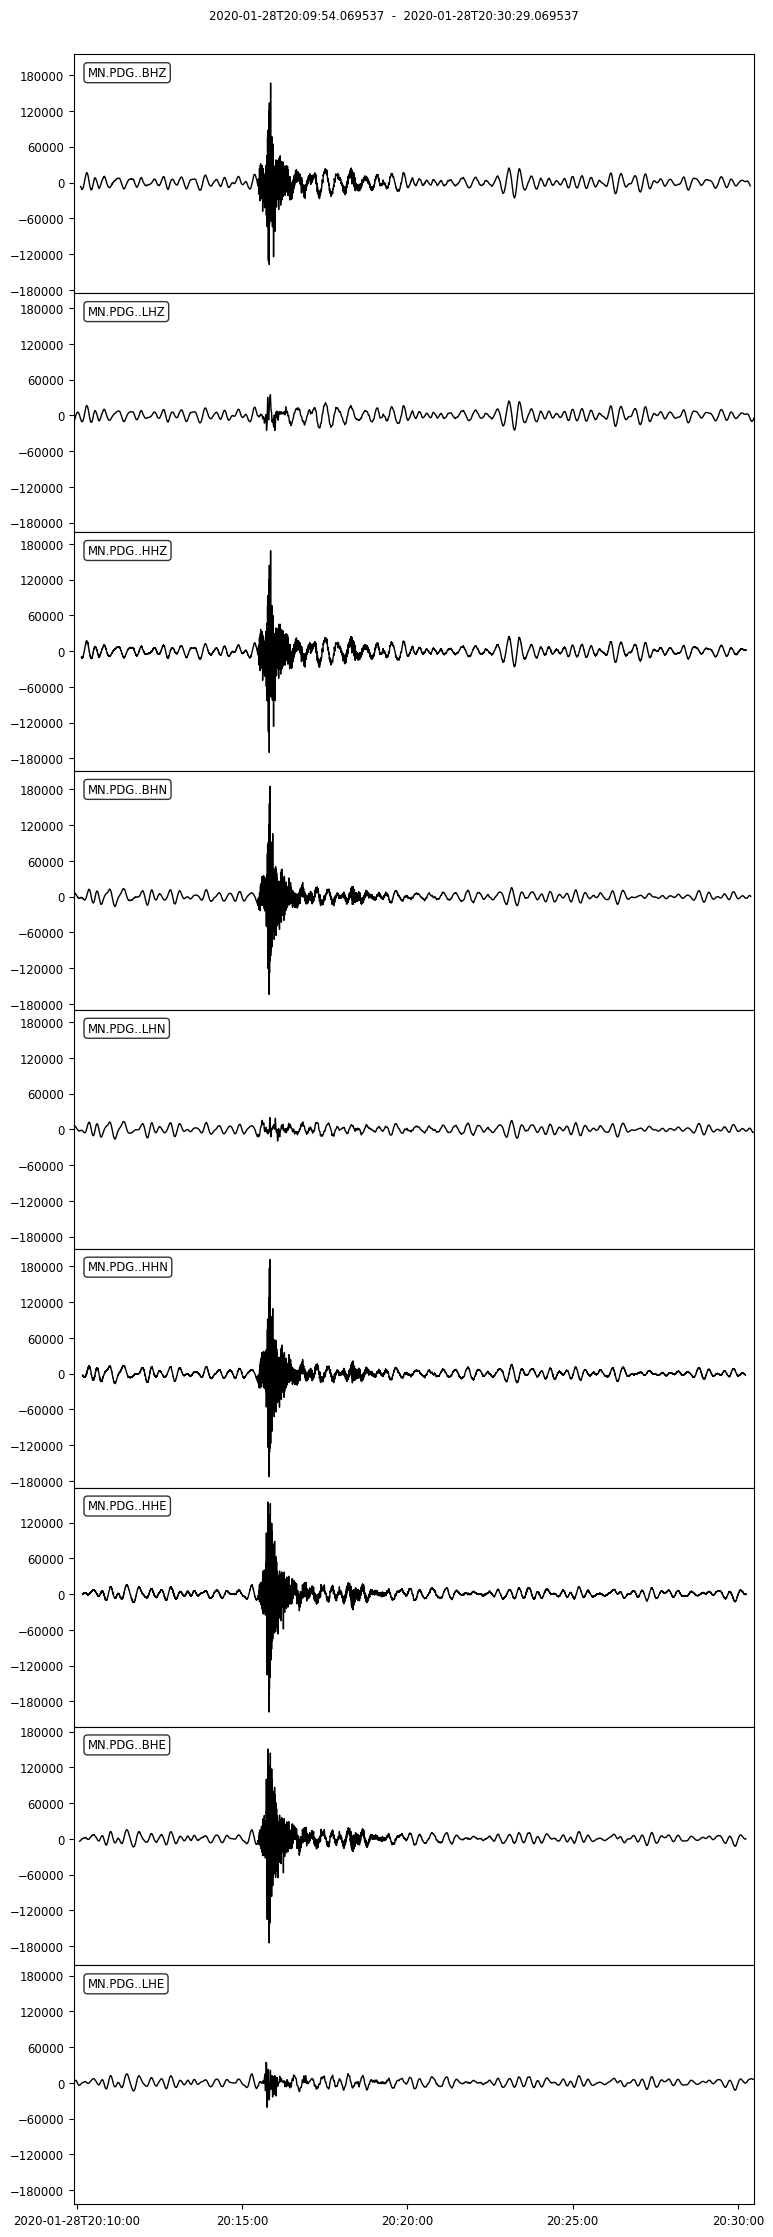

http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=OT&station=TAR1&channel=HH?
3 Trace(s) in Stream:
OT.TAR1..HHN | 2020-01-28T20:10:09.780000Z - 2020-01-28T20:30:11.800000Z | 100.0 Hz, 120203 samples
OT.TAR1..HHE | 2020-01-28T20:10:10.490000Z - 2020-01-28T20:30:13.770000Z | 100.0 Hz, 120329 samples
OT.TAR1..HHZ | 2020-01-28T20:10:10.220000Z - 2020-01-28T20:30:11.350000Z | 100.0 Hz, 120114 samples


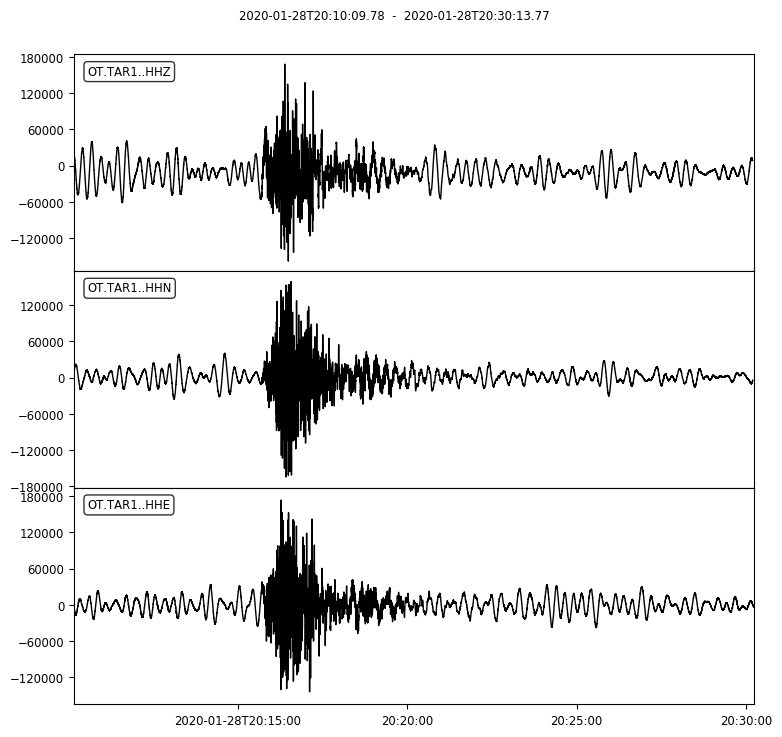

In [28]:
from obspy import read

# Loop through our validated stations, build URL, retrieve and read the data
for s in validated_stations:
    dataselect_url = (
        f"http://eida-federator.ethz.ch/fdsnws/dataselect/1/query?"
        f"start={dt_start_iso}&end={dt_end_iso}&"
        f"network={s[0]}&station={s[1]}&"
        f"channel={s[2]}"
    )
    
    # Print URL used to retrieve given dataset
    print(dataselect_url)
    
    # Request and load the data
    st = read(dataselect_url)
    
    # Print waveform metadata and plot the waveforms
    print(st)
    st.plot()

# 6. Download metadata for verified stations

In [29]:
from obspy import read_inventory

# Loop through our validated stations, build URL, retrieve and read the metadata
for s in validated_stations:
    station_url = (
        f"http://eida-federator.ethz.ch/fdsnws/station/1/query?"
        f"level=channel&"
        f"start={dt_start_iso}&end={dt_end_iso}&"
        f"network={s[0]}&station={s[1]}&"
        f"channel={s[2]}"
    )
    
    # Print URL used to retrieve the metadata
    print(station_url)
    
    # Request and load the metadata
    inv = read_inventory(station_url)
    
    # Print the metadata
    print(inv)

http://eida-federator.ethz.ch/fdsnws/station/1/query?level=channel&start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=SJ&station=BEO&channel=BH?
Inventory created at 2021-03-26T10:16:18.077227Z
	Sending institution: EIDA-Federator (EIDA)
	Contains:
		Networks (1):
			SJ
		Stations (1):
			SJ.BEO (Station Beograd, Serbia)
		Channels (3):
			SJ.BEO..BHZ, SJ.BEO..BHN, SJ.BEO..BHE
http://eida-federator.ethz.ch/fdsnws/station/1/query?level=channel&start=2020-01-28T20:10:10.670309&end=2020-01-28T20:30:10.670309&network=IV&station=MESG&channel=BH?,HH?,LH?
Inventory created at 2021-03-26T10:16:19.734542Z
	Sending institution: EIDA-Federator (EIDA)
	Contains:
		Networks (1):
			IV
		Stations (1):
			IV.MESG (Mesagne)
		Channels (9):
			IV.MESG..BHZ, IV.MESG..BHN, IV.MESG..BHE, IV.MESG..HHZ, 
			IV.MESG..HHN, IV.MESG..HHE, IV.MESG..LHZ, IV.MESG..LHN, 
			IV.MESG..LHE
http://eida-federator.ethz.ch/fdsnws/station/1/query?level=channel&start=2020-01-28T20:10:10.670309&end=2020-

# 7. Quality tools on the orfeus-eu.org
Overview of the EIDA Quality Tools: https://www.orfeus-eu.org/data/eida/quality/

## 7.1. Availability
Availability information can be easily previewed using web tool accessible via https://www.orfeus-eu.org/data/eida/quality/availability/:
![](img/availability.png)

## 7.2. Data Quality Inspector
Data quality inspector rendering advanced waveform metrics is avaiable via https://www.orfeus-eu.org/data/eida/quality/metrics/.

Following statistical parameters can be selected and rendered:
* Quadratic mean
* Standard deviation
* Minimum
* Maximum
* Availability
* Gaps
* Sum of gaps
* Overlaps
* Sum of overlaps
* Median
* Mean
* Lower quartile
* Upper quartile

![](img/inspector.png)